In [1]:
import openml
import pandas as pd
import numpy as np
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import time
import psutil
import warnings
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_percentage_error, roc_curve, roc_auc_score


In [2]:
dataset = openml.datasets.get_dataset(23512)

In [3]:
X, y, categorical_indicator, attribute_names = dataset.get_data(target=dataset.default_target_attribute, dataset_format='dataframe')

X

,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1pt,jet1eta,jet1phi,jet1b-tag,jet2pt,...,jet4eta,jet4phi,jet4b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,0.755421,...,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98045,0.908091,-0.825006,-0.830871,0.736298,1.512713,0.881811,-0.363440,0.006813,1.086538,0.763227,...,-0.187013,0.716785,0.000000,1.317681,1.010795,0.985962,0.957878,1.454672,0.903937,0.786069
98046,2.512898,0.530759,-1.470626,1.641798,1.613386,0.934027,1.521958,-0.049836,0.000000,1.029891,...,0.053673,-0.386483,0.000000,0.774413,0.745263,0.997088,1.392387,0.864681,1.179783,1.086167
98047,0.903699,0.261943,-0.429149,1.892855,0.313687,0.493396,-1.494282,-1.458506,0.000000,0.575505,...,-0.283621,1.110772,3.101961,0.527038,0.607263,1.125286,0.634106,0.115543,0.425828,0.692506
98048,0.566047,-0.317568,0.062561,0.358186,-1.315823,0.691176,1.154583,-0.242759,2.173076,0.680634,...,-0.844943,-0.294922,0.000000,0.747239,1.008975,0.989497,1.203147,0.892492,1.090807,0.888965


In [4]:
X=X[:-1]

X

,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1pt,jet1eta,jet1phi,jet1b-tag,jet2pt,...,jet4eta,jet4phi,jet4b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,0.755421,...,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98044,2.786130,-0.679884,-1.673151,0.854033,1.020573,0.844252,-0.323831,-0.132437,0.000000,0.773299,...,-0.807466,1.054172,0.000000,0.931880,0.880436,1.399047,1.041965,0.875924,1.056742,1.383591
98045,0.908091,-0.825006,-0.830871,0.736298,1.512713,0.881811,-0.363440,0.006813,1.086538,0.763227,...,-0.187013,0.716785,0.000000,1.317681,1.010795,0.985962,0.957878,1.454672,0.903937,0.786069
98046,2.512898,0.530759,-1.470626,1.641798,1.613386,0.934027,1.521958,-0.049836,0.000000,1.029891,...,0.053673,-0.386483,0.000000,0.774413,0.745263,0.997088,1.392387,0.864681,1.179783,1.086167
98047,0.903699,0.261943,-0.429149,1.892855,0.313687,0.493396,-1.494282,-1.458506,0.000000,0.575505,...,-0.283621,1.110772,3.101961,0.527038,0.607263,1.125286,0.634106,0.115543,0.425828,0.692506


In [5]:
y = y[:-1]

In [6]:
le = LabelEncoder()
y = le.fit_transform(y)

y

array([1, 1, 0, ..., 0, 0, 0])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
time_cost = []
memory_cost = []

In [19]:
lgbm_model = lgb.LGBMClassifier(n_estimators=100,learning_rate=0.1,max_depth=6,random_state=42)

start_time = time.time()

lgbm_model.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print("Elapsed Time:", elapsed_time)

memory_usage = psutil.Process().memory_info().rss / 1024**2  # in megabytes
print("Memory Usage:", memory_usage, "MB")

time_cost.append(elapsed_time)
memory_cost.append(memory_usage)

lgbm_accuracy = lgbm_model.score(X_test, y_test)
print("Accuracy:", lgbm_accuracy)

Elapsed Time: 0.46872830390930176
Memory Usage: 371.29296875 MB
Accuracy: 0.7232534421213667


In [20]:
catboost_model = cb.CatBoostClassifier(n_estimators=100,learning_rate=0.1,max_depth=6,random_state=42,verbose=False)

start_time = time.time()

catboost_model.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print("Elapsed Time:", elapsed_time)

memory_usage = psutil.Process().memory_info().rss / 1024**2  # in megabytes
print("Memory Usage:", memory_usage, "MB")

time_cost.append(elapsed_time)
memory_cost.append(memory_usage)

catboost_accuracy = catboost_model.score(X_test, y_test)
print("CatBoost Accuracy:", catboost_accuracy)


Elapsed Time: 2.0272743701934814
Memory Usage: 369.87890625 MB
CatBoost Accuracy: 0.7130035696073432


In [21]:
xgboost_model = xgb.XGBClassifier(n_estimators=100,learning_rate=0.1,max_depth=6,random_state=42)

start_time = time.time()

xgboost_model.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print("Elapsed Time:", elapsed_time)

memory_usage = psutil.Process().memory_info().rss / 1024**2  # in megabytes
print("Memory Usage:", memory_usage, "MB")

time_cost.append(elapsed_time)
memory_cost.append(memory_usage)

xgboost_accuracy = xgboost_model.score(X_test, y_test)
print("XGBoost Accuracy:", xgboost_accuracy)

Elapsed Time: 9.841265439987183
Memory Usage: 374.6015625 MB
XGBoost Accuracy: 0.7210096889342172


In [22]:
print(time_cost)

print(memory_cost)

[0.46872830390930176, 2.0272743701934814, 9.841265439987183]
[371.29296875, 369.87890625, 374.6015625]


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.70      0.70      9230
           1       0.74      0.74      0.74     10380

    accuracy                           0.72     19610
   macro avg       0.72      0.72      0.72     19610
weighted avg       0.72      0.72      0.72     19610



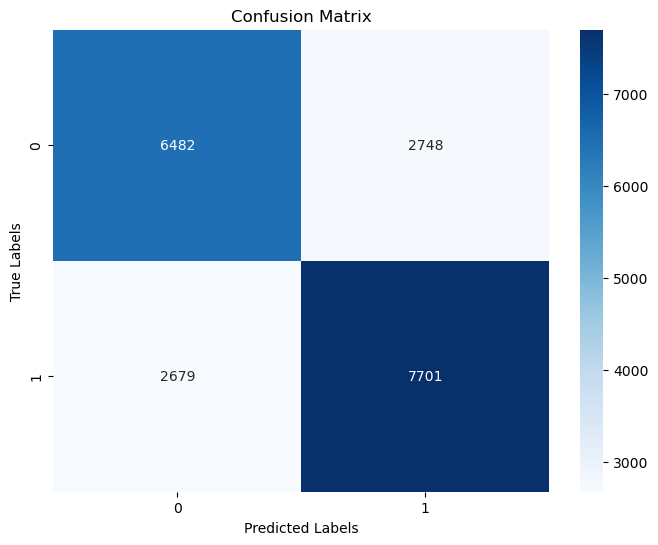

In [11]:
y_pred_lgbm = lgbm_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_lgbm))

class_labels = np.unique(np.concatenate((y_test, y_pred_lgbm)))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_lgbm), annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.69      9230
           1       0.73      0.73      0.73     10380

    accuracy                           0.71     19610
   macro avg       0.71      0.71      0.71     19610
weighted avg       0.71      0.71      0.71     19610



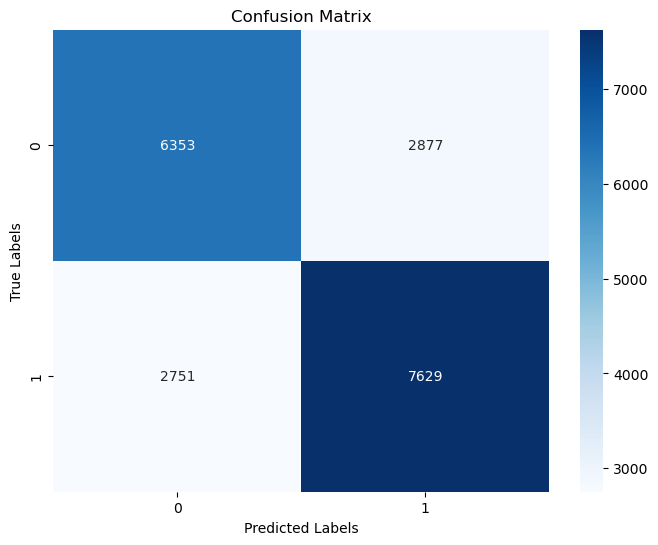

In [12]:
y_pred_cat = catboost_model.predict(X_test)

y_pred_cat = y_pred_cat.flatten()

print("Classification Report:")
print(classification_report(y_test, y_pred_cat))

class_labels = np.unique(np.concatenate((y_test, y_pred_cat)))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_cat), annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.70      0.70      9230
           1       0.73      0.74      0.74     10380

    accuracy                           0.72     19610
   macro avg       0.72      0.72      0.72     19610
weighted avg       0.72      0.72      0.72     19610



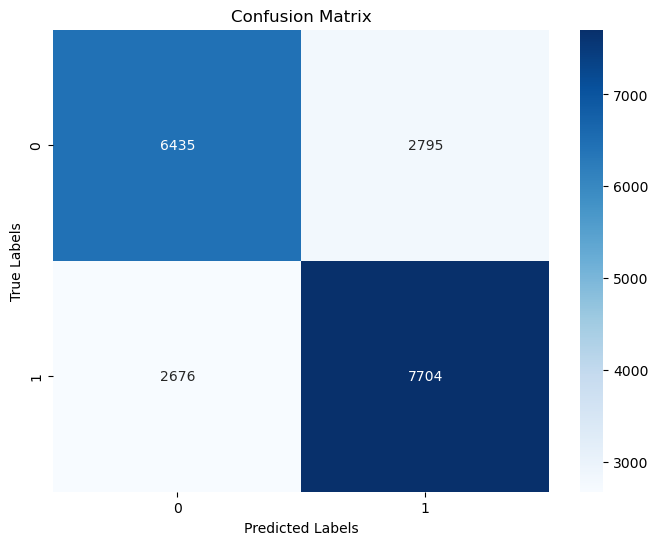

In [13]:
y_pred_xgb = xgboost_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

class_labels = np.unique(np.concatenate((y_test, y_pred_xgb)))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

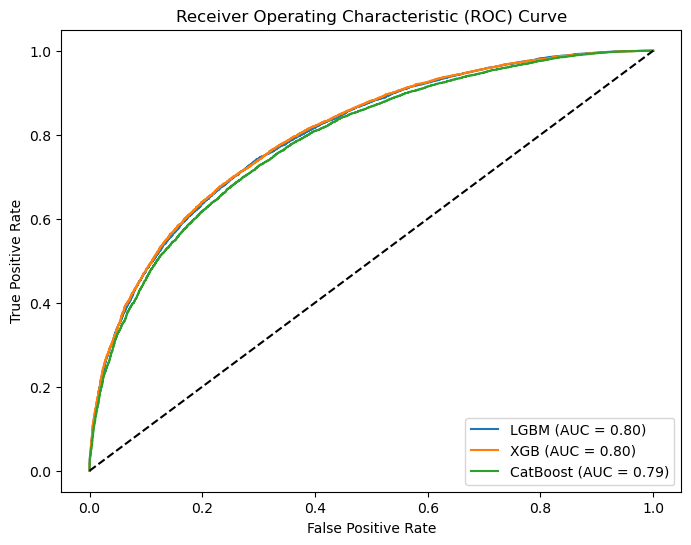

In [14]:
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]
y_pred_proba_xgb = xgboost_model.predict_proba(X_test)[:, 1]
y_pred_proba_cat = catboost_model.predict_proba(X_test)[:, 1]

fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_test, y_pred_proba_lgbm)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_proba_xgb)
fpr_cat, tpr_cat, thresholds_cat = roc_curve(y_test, y_pred_proba_cat)

auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
auc_cat = roc_auc_score(y_test, y_pred_proba_cat)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lgbm, tpr_lgbm, label='LGBM (AUC = {:.2f})'.format(auc_lgbm))
plt.plot(fpr_xgb, tpr_xgb, label='XGB (AUC = {:.2f})'.format(auc_xgb))
plt.plot(fpr_cat, tpr_cat, label='CatBoost (AUC = {:.2f})'.format(auc_cat))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [15]:
logreg = LogisticRegression()

warnings.filterwarnings("ignore")

start_time = time.time()

logreg.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print("Elapsed Time:", elapsed_time)

memory_usage = psutil.Process().memory_info().rss / 1024**2  # in megabytes
print("Memory Usage:", memory_usage, "MB")

logreg_accuracy = logreg.score(X_test, y_test)

print("logreg Accuracy:", logreg_accuracy)

Elapsed Time: 0.4308509826660156
Memory Usage: 385.22265625 MB
logreg Accuracy: 0.6389597144314125


Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.53      0.58      9230
           1       0.64      0.73      0.68     10380

    accuracy                           0.64     19610
   macro avg       0.64      0.63      0.63     19610
weighted avg       0.64      0.64      0.63     19610



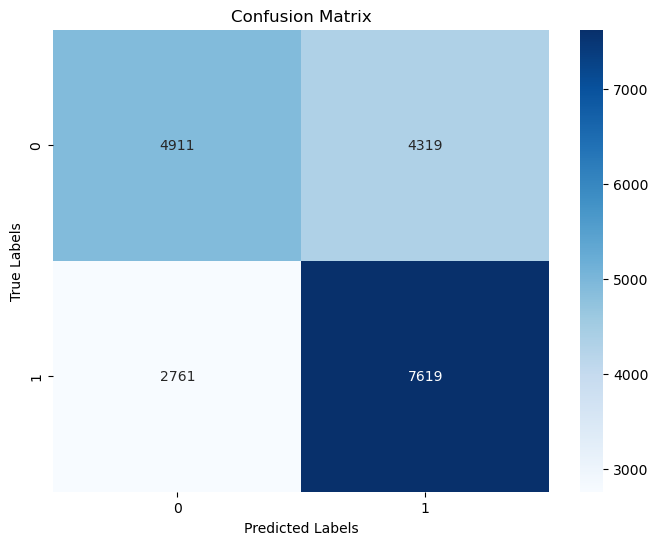

In [17]:
log_pred = logreg.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, log_pred))

class_labels = np.unique(np.concatenate((y_test, log_pred)))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, log_pred), annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()